In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [2]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]

# Put aside an array for the patterns
# This will be one image per digit (ground truth for that category)
patterns = np.zeros((10,784))

# Set aside one image per class to store (10 images in total), random selection
for category in range(10):
    inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
    patterns[category,:] = 1.0*(images[inclass[random.randint(0,len(inclass))],:] > 0)

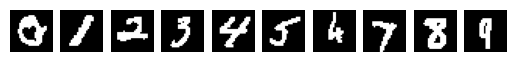

In [4]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [5]:
class hopfield_network(object):
    """
    Here is a class for a hopfield network.
    """

    # The initialization function for the hopfield network
    def __init__(self,N):
        """
        __init__(N)

        Initializing the Hopfield network with N units, empty weight matrices, and all states as -1.

        Parameters:
         - N: the number of units in the network
        """
        # Number of units
        self.N = N  

        # N x N weight matrix, initialized with all zero entries
        self.weights = np.zeros((N, N))  

        # Initialize all neurons to -1 for now
        # We will always provide a starting state for the network so this doesn't actually matter
        self.state = np.full(N, -1)  

    # The function for setting the activity state of the network
    def set_state(self,activity):
        """
        set_state(activity)

        Sets the state of the network to the pattern given by activity.

        Parameters:
         - activity: the activity state that we want our hopfield network to take on

        You do not need to change this function.
        """

        # set the state to activity
        self.state = activity



    # The function for updating the state of the network
    def update(self):
        """
        update()

        Updates the state of a single unit that is chosen at random.

        Returns:
        - the updated state of the network.
        """

        # Randomly select a unit to be updated
        i = random.randint(0, self.N - 1)

        # Compute the new state based on the sign of the weighted sum of other neurons
        # This is using a threshold theta = 0
        state_sign = np.sign(np.dot(self.weights[i], self.state))

        # State is updated to either -1 or 1
        self.state[i] = 1 if state_sign == 1 else -1

        return self.state

    # The function for storing one image at a time
    def store_one(self,image):
        """
        Stores one pattern into the Hopfield network through Hebbian learning.

        Parameters:
        - image: 1D array of length N that represents a 28 x 28 image

        NOTE: image is in binary but our network has bipolar activity states
        """

        # Convert the binary image to bipolar to store the representation of the image in the network
        bipolar_image = binary_to_bipolar(image)

        # Design a one-pattern-at-a-time learning rule function
        # How will you calculate the weight and threshold updates for the network?
        # I do the weight updates just fine but WHAT DOES IT MEAN BY THRESHOLD UPDATES???

        # Hebbian learning rule involves the outer product of the pattern with itself
        self.weights += np.outer(bipolar_image, bipolar_image)

        # There shouldn't be any self connections in the network so we can set the diagonal of the weight matrix to 0s
        np.fill_diagonal(self.weights, 0)

    # The function for storing multiple images in one shot
    def store_multi(self,images):
        """
        Stores multiple patterns at once into the Hopfield network using Hebbian learning

        Parameters:
        - images: 2D array of shape (p, N) where p is the number of patterns and N is the number of units in the network

        NOTE: images is in binary, so we have to do the same conversion to bipolar as we did in store_one
        """

        # Finding out how many patterns there are, this will be our normalization constant
        num_patterns = images.shape[0]
        
        # Convert the binary image to bipolar to store the representation of the images in the network
        bipolar_images = binary_to_bipolar(images)

        # Compute the weight matrix using matrix multiplication of transpose and original
        # Get the sum over all training patterns
        self.weights += np.dot(bipolar_images.T, bipolar_images) / num_patterns

        # There shouldn't be any self connections in the network so we can set the diagonal of the weight matrix to 0s
        np.fill_diagonal(self.weights, 0)

In [6]:
# Some helper functions for generating test images

  # Helper function to convert the patterns of the binary images to be bipolar
def binary_to_bipolar(binary_image):
    """
    Convert a binary image {0, 1} to bipolar {-1, 1}.

    Parameters:
    - binary_image: 1D array with binary values {0, 1}

    Returns:
    - 1D array with bipolar values {-1, 1}
    """
    # 0 becomes -1 and 1 remains as 1
    return 2 * binary_image - 1


# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """
    new_image = test_noise(image)

    This function takes an image, converts it from binary to bipolar, adds noise to it, and returns it.

    Parameters:
    - image: 1D array with binary values {0, 1}
    - noise_level: between 0-1, try experimenting with this

    Returns:
    - noisy_bipolar_image: 1D array with noisy bipolar values {-1, 1}
    """
    # We want to store bipolar patterns in our network
    bipolar_image = binary_to_bipolar(image)

    # create a mask for adding noise to the image
    image_mask = random.uniform(size=image.shape) < noise_level

    # Flip bipolar values where the mask is on (i.e. change -1 to 1, and 1 to -1)
    noisy_bipolar_image = np.where(image_mask, -bipolar_image, bipolar_image)

    return noisy_bipolar_image


# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    new_image = test_combo(image1,image2)

    This function takes a pair of images, combines them, and converts the result to bipolar before returning it.

    Parameters:
    - image1: 1D array with binary values {0, 1}
    - image2: 1D array with binary values {0, 1}
    - image1_weight: between 0-1, try experimenting with this

    Returns:
    - bipolar_combo: 1D array with bipolar values {-1, 1} sample from either image1 or image2
    """

    # Create a mask for mixing the images
    # Picks which pixels from image1 will be used
    image1_mask = random.uniform(size=image1.shape) < image1_weight

    # Combine the images by using the mask, the result is still in binary
    binary_combo = image1_mask*image1 + (1-image1_mask)*image2

    # Convert binary to bipolar
    bipolar_combo = binary_to_bipolar(binary_combo)

    return bipolar_combo

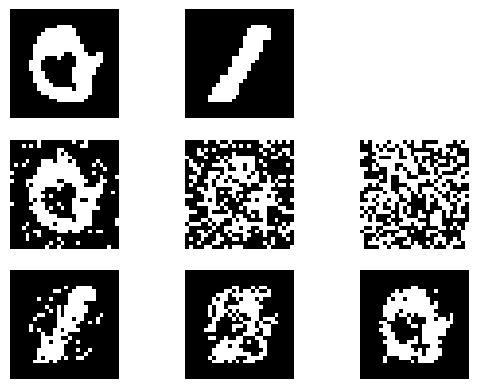

In [7]:
# Test the helper functions to make sure they work

# Pick any two images to test the helper functions
# I have chosen 0 and 1
image1 = patterns[0]
image2 = patterns[1]

# Create a little array for storage
test_images = np.zeros((2,3,784))

# Generate a series of noise images
test_images[0,0,:] = image_noise(image1)
test_images[0,1,:] = image_noise(image1,noise_level=0.3)
test_images[0,2,:] = image_noise(image1,noise_level=0.5)

# Generate a series of combo images
test_images[1,0,:] = image_combo(image1,image2,image1_weight=0.2)
test_images[1,1,:] = image_combo(image1,image2)
test_images[1,2,:] = image_combo(image1,image2,image1_weight=0.8)

# Plot the images, plus the originals on top
fig, axs = plt.subplots(3,3)
axs[0,0].imshow(image1.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].imshow(image2.reshape((28,28)), cmap='gray')
axs[0,1].axis("off")
axs[0,2].axis("off")
for c in range(3):
    axs[1,c].imshow(test_images[0,c,:].reshape((28,28)), cmap='gray')
    axs[1,c].axis("off")
    axs[2,c].imshow(test_images[1,c,:].reshape((28,28)), cmap='gray')
    axs[2,c].axis("off")
plt.show()

In [8]:
# Create a Hopfield network and train it

# Flag for whether to store one pattern at a time
one_pattern = False

# Construct the network with 784 units, one for each pixel in the 28 x 28 image
hnet = hopfield_network(784)
    
# I AM ONLY STORING TWO PATTERNS AT A TIME TO AVOID ISSUES WITH INTERFERENCE
# Here is where you can define which patters you would like the network to store
# Feel free to change them to any digit 0-9
training_patterns = np.array([patterns[0], patterns[1]])

# Store the patterns one at a time
if one_pattern:
    for pattern in training_patterns:
        hnet.store_one(pattern)

# Store all of the patterns at once
else:
    hnet.store_multi(training_patterns)

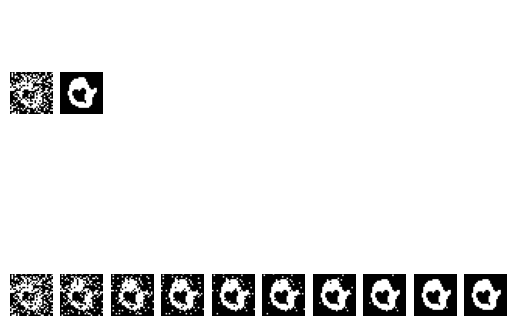

In [9]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a noisy version of an image that was stored

# Number of time-steps to run the network for
# Note that we are performing multiple updates at each time step!
# But we only store an activity state once per time step
numsteps = 10

# Create an array for storing activity states over time
activity = np.zeros((numsteps,784))

# Test using the noisy version of an image as a starting state
# I'm picking 0 because that is a pattern that I have stored, but you can change it to any pattern
image = patterns[0]

# Store the starting activity state and set the network to that state
activity[0,:] = image_noise(image, noise_level=0.3)
hnet.set_state(np.copy(activity[0,:]))

for t in range(numsteps-1):
    # Perform 400 updates at each time step
    for x in range(400):
        hnet.update()
    activity[t+1,:] = hnet.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape((28,28)), cmap='gray')
axs[0,1].imshow(image.reshape((28,28)), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape((28,28)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show()

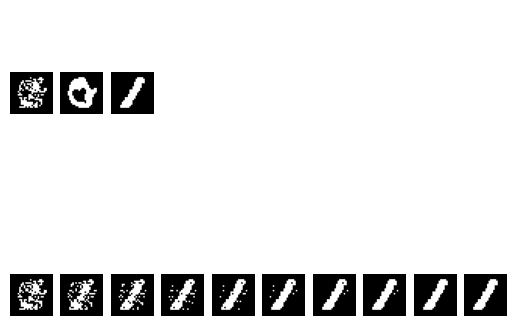

In [10]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a combination of two images that were stored

# Number of time-steps to run the network for
# Note that we are performing multiple updates at each time step!
# But we only store an activity state once per time step
numsteps = 10

# Create an array for storing activity states over time
activity = np.zeros((numsteps,784))

# Test using a combo of two images
# I'm picking 0 and 1 because those are the patterns that I have stored, but you can change them to any patterns
image1 = patterns[0]
image2 = patterns[1]

# Store the starting activity state and set the network to that state
activity[0,:] = image_combo(image1,image2)
hnet.set_state(np.copy(activity[0,:]))

# Multiple updates per time step, but only storing the activity state once
for t in range(numsteps-1):
    for x in range(350):
        hnet.update()
    activity[t+1,:] = hnet.update()

# plot the results
fig, axs = plt.subplots(2,numsteps)
axs[0,0].imshow(activity[0,:].reshape((28,28)), cmap='gray')
axs[0,1].imshow(image1.reshape((28,28)), cmap='gray')
axs[0,2].imshow(image2.reshape((28,28)), cmap='gray')
for c in range(numsteps):
    axs[1,c].imshow(activity[c,:].reshape((28,28)), cmap='gray')
    axs[0,c].axis("off")
    axs[1,c].axis("off")
plt.show()